In [390]:
# %%R -i df -o 


# library()

# Location patterns 1 - global chromosome characteristics

This notebook explores the relationship between inversion coordinates and chromosome characteristics related to recombination rates. 



In [391]:
# Initiate notebook with packages
# -------------------------------

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import scipy.stats
import math
from plotnine import ggplot, geom_histogram, aes, geom_bar, scale_x_discrete, theme, element_text, ggtitle, xlab, ylab, facet_wrap, geom_point, stat_smooth, annotate, geom_text, geom_boxplot, geom_col, facet_grid

# Load chromosome data
# -------------------------------

gap = pd.read_csv('../data/raw/gap.txt', sep = '\t', header = None )
gap.set_axis(['bin','chrom','chromStart','chromEnd','ix','n','size','type','bridge'], axis = 1, inplace = True)


band = pd.read_csv('../data/raw/cytoBand.txt', sep = '\t', header = None )
band.set_axis(['chrom','chromStart','chromEnd','name','gieStain'], axis = 1, inplace = True)

# Load and clean inversion data
# -------------------------------

inv = pd.read_csv('../data/use/InversionsAnnotation_133Inv_20211117.csv', sep = '\t', skiprows=1, skip_blank_lines=True)
inv = inv.iloc[:,[0,1,2,11,12,13,14]]
inv = inv.dropna()

print("We will be analyzing " + str(inv.shape[0]) + " inversions")


We will be analyzing 135 inversions


## Differences in distribution between chromosomes

It is known that chrX has more inversions, I will be analysing only autosomes in this document. 

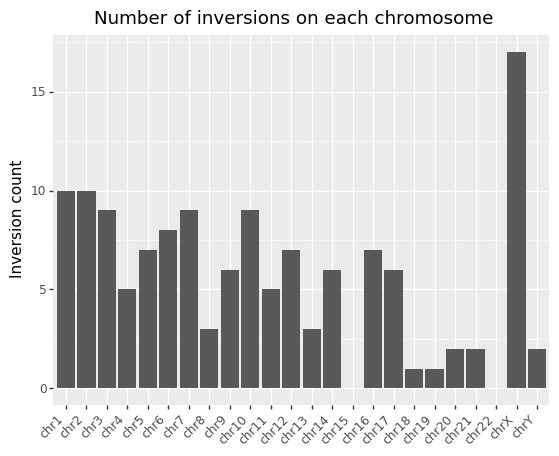

<ggplot: (8753405677478)>

In [392]:
# Distribution of inversions by chromosome overview - a plot
# -------------------------------

# Make barplot values 
hist = DataFrame(inv.Chr.value_counts())

# Set chromosome names list
a = np.char.array(list(map(str,range(1,23)))+["X", "Y"])
b = np.char.array(["chr"] * 24)
chrNames = b+a 

# Make plot 
(
    ggplot(hist)+
        geom_bar(aes(x = hist.index, y = "Chr"), stat="identity")+
        scale_x_discrete(limits = chrNames)+
        theme( axis_text_x = element_text(angle = 45, vjust = 1, hjust=1))+
        ylab("Inversion count")+
        ggtitle("Number of inversions on each chromosome")

)



### Chromosome size

There is a strong correlation between


/home/rgomez/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


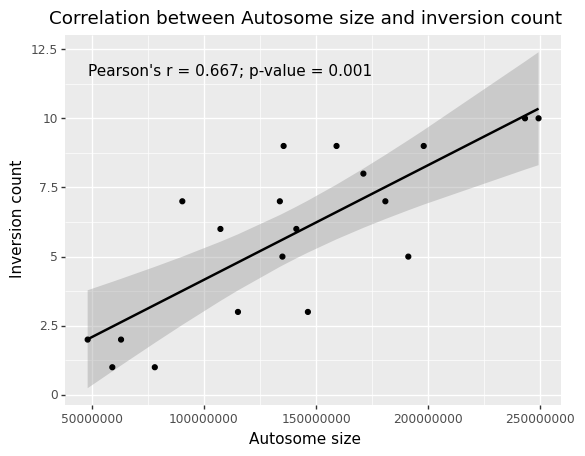

<ggplot: (8753405429986)>

In [393]:
# Distribution of inversions by chromosome size
# -------------------------------

# Take chromosome sizes
chromSize = gap[(gap.type == "telomere") & (gap.chromStart!=0)][["chrom", "chromEnd"]]

# Join with inversion count
prop = pd.merge(chromSize, hist, left_on="chrom", right_index=True)

# Calculate correlation between chrom size and inversion count
np.corrcoef(prop["chromEnd"],prop.Chr)
corr = scipy.stats.pearsonr(prop.chromEnd, prop.Chr)
corrMessage = "Pearson's r = {:.3f}; p-value = {:.3f}".format(corr[0], corr[1])

# Plot correlation
plotSubset = prop[~prop["chrom"].isin(["chrX", "chrY"])]

(
    # ggplot(prop)+
    ggplot(plotSubset)+
    stat_smooth(aes(x = "chromEnd", y = "Chr"), method = "lm") +    
    geom_point(aes(x = "chromEnd", y = "Chr")) +
    geom_text(aes(label="label", x = plotSubset.chromEnd.min(), y = plotSubset.Chr.max()*1.2), data=DataFrame( {"label":[corrMessage]}), va="top", ha="left")+
    ggtitle("Correlation between Autosome size and inversion count")+
    ylab("Inversion count")+xlab("Autosome size")  

)



### Inversion and chromosome sizes, grouped
Incidence of inversions (or differences in inv. sizes or recurrence) in big vs. small chromosomes.


/home/rgomez/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/rgomez/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


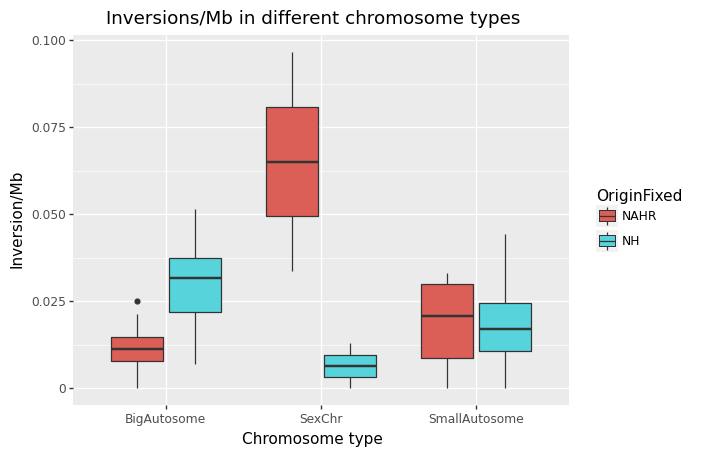

<ggplot: (8753408652638)>

In [394]:
# Distribution of inversions by chromosome size, grouped - BOXPLOT
# -------------------------------

# Set chromosome types list
chrTypes = ( ["BigAutosome"] * 12 + ["SmallAutosome"] * 10 + ["SexChr"] * 2)

# Join chromosome types with chromosome names
chrClassified = DataFrame({"chrNames":chrNames, "chrTypes": chrTypes})

# Join chromosome types to inversion info
inv = pd.merge(inv, chrClassified,  left_on = "Chr", right_on = "chrNames" )

Ori_fixed =  inv["Origin"].replace(regex = ["NAHR.*"], value = "NAHR" )
Ori_fixed = Ori_fixed.replace(regex = ["NH.*"], value = "NH" )
inv["OriginFixed"] = Ori_fixed

# Make per-chromosome inversion counts
inv_grouped = inv.groupby(["OriginFixed","Chr" ])
IDs_grouped = inv_grouped["INV"]

IDs_counted = IDs_grouped.size().unstack().melt( ignore_index= False )
IDs_counted["OriginFixed"] = IDs_counted.index

# Add chromosome size
proportions = pd.merge(IDs_counted, chromSize, left_on = "Chr", right_on="chrom")
proportions["value"] = proportions["value"].replace(np.NaN, 0)
proportions["InvsPerMb"] = proportions["value"] / (proportions["chromEnd"]/1000000)


# Join inversion counts with chrTypes
ICounts_CTypes = pd.merge(proportions, chrClassified, left_on = "Chr", right_on = "chrNames" )

# Make boxplot
(
    ggplot(ICounts_CTypes)+
    geom_boxplot(aes(x = "chrTypes", fill = "OriginFixed", y = "InvsPerMb"))+
    ggtitle("Inversions/Mb in different chromosome types")+
    ylab("Inversion/Mb")+xlab("Chromosome type") 

)



/home/rgomez/anaconda3/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/rgomez/anaconda3/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


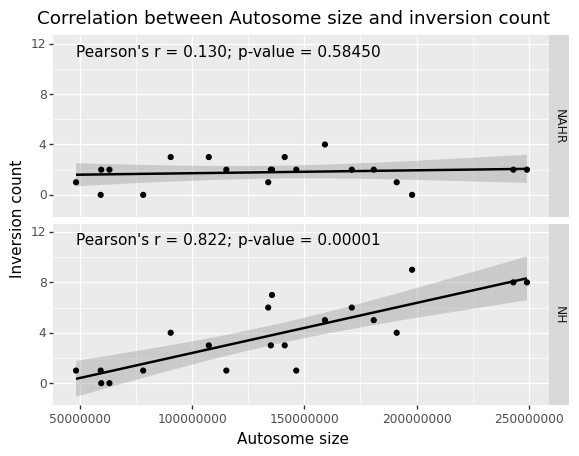

<ggplot: (8753403904597)>

In [395]:
# Distribution of inversions by chromosome size, grouped - CORRELATION
# -------------------------------

IC_CT_auto = ICounts_CTypes[ ~ ICounts_CTypes["chrNames"].isin(["chrX", "chY"])]

# Calculate correlation between chrom size and inversion count for both groups V2
tab_NAHR = IC_CT_auto[IC_CT_auto.OriginFixed == "NAHR"]
tab_NH = IC_CT_auto[IC_CT_auto.OriginFixed == "NH"]

correl = DataFrame( [scipy.stats.pearsonr(tab_NAHR.chromEnd, tab_NAHR.value), scipy.stats.pearsonr(tab_NH.chromEnd, tab_NH.value) ], columns=["correl", "pval"])
correl["OriginFixed"] = ["NAHR", "NH"]


(
    ggplot(IC_CT_auto)+
    stat_smooth(aes(x = "chromEnd", y = "value"), method = "lm") +    
    geom_point(aes(x = "chromEnd", y = "value")) +
    geom_text( aes(label="correl", x = plotSubset.chromEnd.min(), y = plotSubset.Chr.max()*1.2 ) , data = correl ,  va="top", ha="left" , format_string = "Pearson's r = {:.3f};")+
    geom_text( aes(label="pval", x = plotSubset.chromEnd.min()*2.5, y = plotSubset.Chr.max()*1.2 ) , data = correl ,  va="top", ha="left" , format_string = "p-value = {:.5f}")+
    facet_grid("OriginFixed ~ .") +
    ggtitle("Correlation between Autosome size and inversion count")+
    ylab("Inversion count")+xlab("Autosome size")  

)


### Chromosome global recombination rate
Mean chromosome recombination rate vs. inversion number, sizes or recurrence.


## Differences in distribution within chromosomes

I can measure random distribution along a space: https://basicmedicalkey.com/random-distribution-of-cases-in-time-and-space

Check Drosophila Buzzatti dividing chromosome into 5 chunks

Also, proximity to centromere/telomere


In [396]:
# Calculate chromosome arms
# ---------------------------------------

# Select centromeres as p arm End
center = band[(band['gieStain'] == 'acen') & (band['name'].str.startswith('p') )]
center = center[['chrom', 'chromEnd']]

# Select chromosome end as q arm End
groupedBand = band['chromEnd'].groupby(band['chrom'])
end = DataFrame(groupedBand.max() )
end.reset_index(level=['chrom'], inplace = True)

# Set q arm Start
end = pd.merge(end, center, on = 'chrom')
end.set_axis(['chrom','chromEnd','chromStart'], axis = 1, inplace = True)

# Set p arm Start
center['chromStart'] = 0

# Set p and q flags
center['chromArm']='p'
end['chromArm']='q'

# Join data
chromArms = pd.concat([center, end])

# Armsize
chromArms["ArmSize"] = chromArms["chromEnd"] - chromArms["chromStart"] # no need to sum-rest, 0 based



# Calculate % of arm in which the center of the inversion is placed
# ---------------------------------------

# Make center of inversion
inv["Center_pos"] = inv["BP1_1.1"] + ((inv["BP2_2.1"]- inv["BP1_1.1"] +1 )/2) -1 # now it is 0-based

# For each inversion, calculate chromosome arm
inv["chromArm"] = [ chromArms[(chromArms.chromStart < row.Center_pos )& (chromArms.chromEnd > row.Center_pos) & (row.Chr == chromArms.chrom)]["chromArm"].iloc[0] for index, row in inv.iterrows() ]

# Calculate % of arm where inversion is, 0 = start, 100 = end
percList = []

for index, row in inv.iterrows():
    myrow = chromArms[(chromArms.chrom == row.Chr) & (chromArms.chromArm == row.chromArm)].iloc[0]
    value = ((row.Center_pos - myrow.chromStart ) / myrow.ArmSize ) * 100
    percList.append(value)

inv["armPerc"] = percList

# Change percentages to be 0 = centromere, 100 = telomere
mask = (inv.chromArm == "p")
inv_valid = inv[mask]

inv["armPerc_Telocen"] = inv["armPerc"]
inv.loc[mask, 'armPerc_Telocen'] = 100 - inv_valid["armPerc"]

/home/rgomez/anaconda3/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/rgomez/anaconda3/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


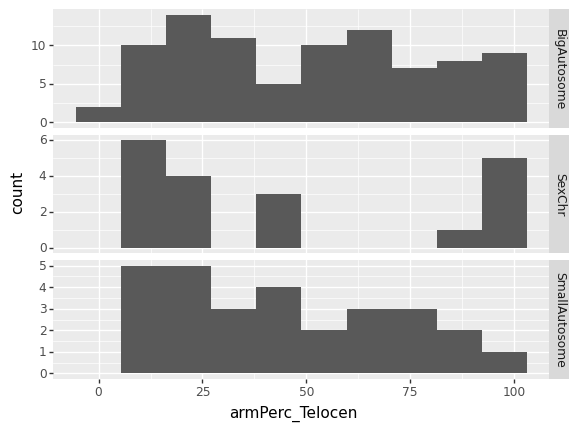

<ggplot: (8753407399078)>

In [397]:
(
    ggplot(inv)+
    geom_histogram(aes(x = "armPerc_Telocen"), bins=10)+
    facet_grid("chrTypes ~ .", scales = "free")
)

/home/rgomez/anaconda3/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/rgomez/anaconda3/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


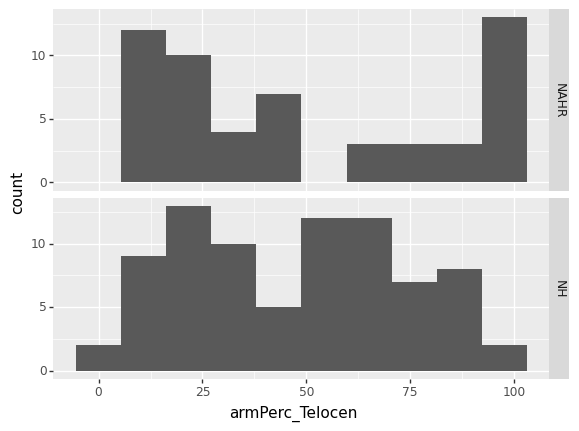

<ggplot: (8753407399150)>

In [398]:
(
    ggplot(inv)+
    geom_histogram(aes(x = "armPerc_Telocen"), bins=10)+
    facet_grid("OriginFixed ~ .", scales = "free")
)

/home/rgomez/anaconda3/lib/python3.8/site-packages/plotnine/facets/facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/rgomez/anaconda3/lib/python3.8/site-packages/plotnine/facets/facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


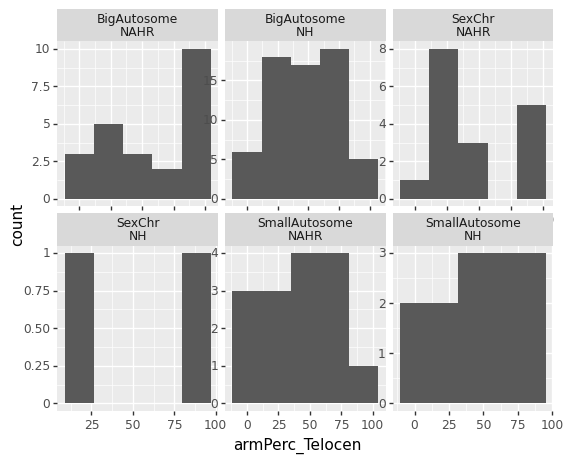

<ggplot: (8753405652583)>

In [408]:
(
    ggplot(inv)+
    geom_histogram(aes(x = "armPerc_Telocen"), bins=5)+
    facet_wrap("~ chrTypes + OriginFixed", scales = "free") # facet_wrap?
)

In [ ]:



AÑADIR mB DE INV POR MB DE CHR
PSEUDOAUTOSOMAL REGION

SyntaxError: invalid syntax (<ipython-input-384-cb58c68afa9f>, line 1)